In [1]:
%load_ext ipython_namespaces

import numpy as np
from ripser import ripser
from numpy.linalg import pinv as pseudoinverse
import matplotlib.pyplot as plt

from persim import plot_diagrams

def scatter_cocycle(distance, points, cocycle, threshold):
    """Plot a cocycle at threshold.
    
    :note: susbstitute to plotCocycle2D for performance reasons
    
    :warning: it does only plots the edges available at threshold
    """
    under_threshold = (distance < threshold) & (distance > 0)
    # now for every edge under the threshold we want to plot
    # the edge with some fancy color and the value of our co-cycle
    # on that edge
    edges = np.transpose(np.triu(under_threshold).astype(int).nonzero())
    edges_coords = points[edges] # for every tuple (edge, start, end) there is an entry
    xs, ys = edges_coords[:,:,0], edges_coords[:,:,1]
    l_xs, l_ys = np.linspace(xs[:,0], xs[:,1], num=10), np.linspace(ys[:,0], ys[:,1], num=10)
    plt.plot(l_xs, l_ys)


In [2]:
def border_matrix(lv, le):
    """Computes the border matrix.
    
    Yes it's quadratic (len(lv) * len(le)) but who cares now.
    
    :param lv: list of vertices
    :type lv: numpy.ndarray
    :param le: list of edges
    :type le: numpy.ndarray
    
    :return: the border matrix
    :rtype: numpy.ndarray
    """
    columns = len(lv)
    rows = len(le)
    M = np.zeros((rows, columns))
    for c, vertex in enumerate(lv):
        for r, edge in enumerate(le):
            if vertex in edge:
                start, end = edge[0], edge[1]
                M[r,c] = 1 if vertex == start else -1
    return M

def basis_from_edges(E):
    """Returns a sequence of the edges from the matrix E.
    
    Given the edge matrix we compute the basis
    for the chains by taking all the edges from E
    and returning the pairs [i,j].
    
    :param E: the edges matrix.
    :type E: numpy.ndarray
    
    :return: sequence of edges in form [i,j]
    :rtype: numpy.ndarray
    """
    ones = np.triu(E)
    return np.transpose(ones.nonzero())

def from_distance(D, threshold=np.infty):
    """Returns the operator matrix associated to the threshold filtration.
    
    :param D: The distance matrix for your data set.
    :type D: numpy.ndarry, shape = (k,k)
    
    :param threshold: edges longer than threshold will not be computed.
    :type threshold: np.single | np.double | float
    
    :return: (matrix associated with (co)-border operator, edges matrix, edges base)
    
    :rtype: (numpy.ndarray, numpy.ndarray, numpy.ndarray)
    
    :important: the return matrix is expressed in the edge base
    """
    under_threshold = (D <= threshold) & (D > 0)
    edges = under_threshold.astype(int)
    # there is an edge between r and c when edges[r,c] == 1
    # but we need to put the correct sign in the (co)border
    # matrix as it is 1 IFF r < c and -1 otherwise
    ones = np.triu(edges)
    edge_base = basis_from_edges(ones)
    oriented_edges = ones - ones.T
    # now we have edges with orientation and we can compute
    # our border matrix in the basis computed
    (vertices_num, _) = D.shape
    matrix = border_matrix(range(vertices_num), edge_base)
    return matrix, oriented_edges, edge_base

In [3]:
%%space scratch
# let's make the distance for a triangle
distance = np.array([
    [0, 3, 4],
    [3, 0, 6],
    [4, 5, 0]
])

op, edges, basis = from_distance(distance)

In [4]:
def transform_basis(alpha, basis):
    """Transform the co-cycle alpha to a vector
    represented in basis.
    
    :param alpha: rows of k columns, up to k-1 are the vertices of
    my simplex, column k is the coefficent
    :type alpha: numpy.ndarray
    
    :param basis: rows containing the simplicis in my basis
    :type basis: numpy.ndarray
    
    :return: alpha represented in basis
    :rtype: numpy.ndarray
    """
    components = np.zeros((1, len(basis)), dtype=int)
    for a in alpha:
        for i, b in enumerate(basis):
            if np.all(a[:2] == b):
                components[0, i] = a[2]
                break
        else:
            # this will be executed if
            # break is never reached
            raise ValueError("simplex {} is not in basis".format(a[:-1]))
    return components

def circular_coordinates(p):
    """Transform to circular coordinates.
    
    Returns the same coordinates but modulo Z
    and in the range [0,1)
    
    :param p: coordinates
    :type p: numpy.ndarray
    :rtype: numpy.ndarray
    """
    fractional = p - np.trunc(p)
    correction = np.floor(fractional)
    return fractional - correction

In [25]:
%%space scratch

a = np.array([
    [0, 1, 16],
    [0, 2, 1]
])
b = np.array([
    [0, 1, 16],
    [0, 2, 1]
])
basis = np.array([
    [0,2],
    [0,1],
    [1,2],
])
# outputs array([1, 1, 0])
transform_basis(a, basis)
# outputs array([1, 16, 0])
transform_basis(b, basis)

error = np.array([
    [1, 0, 1] # the simplex [0,1] is not in the basis
])
try:
    # this will error
    transform_basis(error, basis)
except:
    ...

In [26]:
%%space scratch

from numpy.linalg import pinv as pseudoinverse
# compute the example matrix from the assignment
m = np.array([
    [-1, 1, 0],
    [-1, 0, 1],
    [0, -1, 1]
])
p = pseudoinverse(m)
circular_coordinates(p @ (- np.array([1, 0,0])))

array([3.33333333e-01, 6.66666667e-01, 5.48387791e-17])

In [27]:
def close_enough(vertices, distance, threshold=np.infty):
    """Compute if all vertex pairs are close enought.
    
    :param vertices: vertices in our n-cycle
    :type vertices: sequence
    
    :param distance: distance(i,j) return the distance between i and j
    :type distance: callable
    
    :param threshold: threshold distance
    :type threshold: float
    
    :rtype: bool
    """
    for i, vertex in enumerate(vertices):
        for other in vertices[i+1:]:
            if distance(vertex, other) > threshold:
                return False
    return True

def project(alpha, distance, threshold=np.infty):
    """Compute the representative (co)-cycle in the threshold filtration.
    
    :param alpha: the (co)-cycle to project
    :type alpha: numpy.ndarray
    
    :param distance: distance(i,j) return the distance between i and j.
    :type distance: callable
    
    :param threshold: exclude simplices over threshold
    :type threshold: float
    
    :return: alpha without the simplices over the threshold
    :rtype: numpy.ndarray
    """
    (r, _) = alpha.shape
    mask = np.full(r, False, dtype=bool)
    for i, simplex in enumerate(alpha):
        if close_enough(simplex[:-1], distance, threshold):
            mask[i] = True
    if not any(mask):
        raise ValueError("The feature does not exist for time: {}".format(threshold))
    return alpha[mask]

def compute(D, alpha, r, prime):
    """Compute circulare coordinates for alpha.
    
    :param D: Distance matrix
    :param alpha: representative co-cycle
    :param r: threshold
    :param prime: prime field coefficients
    
    :return:
    """
    def distance(i, j):
        """wraps distance matrix to make it callable"""
        return D[i,j]
    alpha_r = project(alpha, distance, r)
    lift = np.copy(alpha_r)
    cap = (prime-1)/2
    to_reduce = (alpha_r[:,-1] > cap).astype(int) # place a 1 when bigger than cap
    lift[:,-1] = alpha_r[:,-1] - prime * to_reduce
    border, edges, basis = from_distance(D) # we are doing co-homology so the border operator is what we want
    b = transform_basis(lift, basis)
    p = pseudoinverse(border)
    y = p @ (- b.T)
    #return border, edges, basis, b, y
    return circular_coordinates(y)

In [8]:
%%space scratch

compute(distance, a, np.infty, 17)

array([[0.33333333],
       [0.33333333],
       [0.33333333]])

We are ready to do the analys as requested.

Here we sample 100 points from the circle and we will get circular coordinates for each one of them.

This means that for our cocyle $\alpha$ we will find a $\beta = \iota \alpha + \partial^{0}(f)$ in the same class.

What we care for is the values of $f$ on the vertices.

In [9]:
%%space deterministic-circle

N=100
t = np.linspace(0, 2*3.1415,N , endpoint=False)
x = np.transpose([np.cos(t), np.sin(t)])

result = ripser(x, coeff=2, maxdim=2, do_cocycles=True)

alpha = result['cocycles'][1][-1] # take the last 1-dim (co)cycle
birth_time, death_time = result['dgms'][0][-1]
D = result['dperm2all']

f = compute(D, alpha, death_time - 1e-10, 2)

Now that we have our values for $f$ we can plot the geometrical realization of our points
and color code them using the circular coordinates.

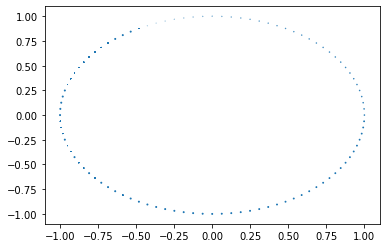

In [10]:
%%space deterministic-circle
plt.scatter(x[:,0], x[:,1], f)

In [11]:
%%space sampling-circle

N=100
t = np.linspace(0, 2*3.1415,N , endpoint=False)
x = np.transpose([np.cos(t), np.sin(t)]) + 0.2 * np.random.random((N,2))

result = ripser(x, coeff=2, maxdim=2, do_cocycles=True)

alpha = result['cocycles'][1][-1] # take the last 1-dim (co)cycle
birth_time, death_time = result['dgms'][0][-1]
D = result['dperm2all']

f = compute(D, alpha, death_time - 1e-10, 2)

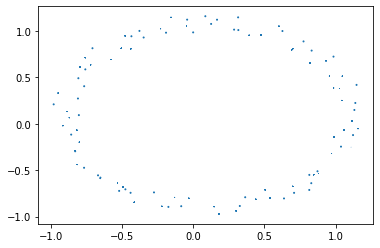

In [12]:
%%space sampling-circle
plt.scatter(x[:,0], x[:,1], f)

In [13]:
from scipy.linalg import norm

def flat_torus_distance(data):
    """Compute the distance matrix for euclidean norm on the torus.
    
    :param data: points on the torus
    :type data: numpy.ndarray
    
    :return: matrix M such that M[i,j] is the distance between data[i] and data[j]
    :rtype: numpy.ndarray
    
    For any replication (so N/S, W/O) we generate new points p by translation
    in the 9 directions ({-1,0,1}, {-1,0,1}) and then we can use the euclidean
    distance to compute the 
    """
    # translations to identified points
    t = np.asarray([
        [-1,  1],
        [ 0,  1],
        [ 1,  1],
        [-1,  0],
        [ 0,  0],
        [ 1,  0],
        [-1, -1],
        [ 0, -1],
        [ 1, -1]
    ])
    (r,c) = data.shape
    n = max(r,c)
    M = np.zeros((n,n))
    for i, p in enumerate(data):
        ps = np.repeat(p.reshape(1,2), 9, axis=0) + t
        for j, q in enumerate(data[i+1:]):
            # here we have unique pairs (i,j)
            # from the uppper triangular
            qs = np.repeat(q.reshape(1,2), 9, axis=0)
            ds = norm(ps - qs, ord=2, axis=1)
            d =  np.min(ds)
            M[i,i + 1 + j] = d
            M[i + 1 + j,i] = d
    return M

In [14]:
%%space scratch
points = np.array([
    [1/3,1/3],
    [2/3,2/3]
])
flat_torus_distance(points)

array([[0.        , 0.47140452],
       [0.47140452, 0.        ]])

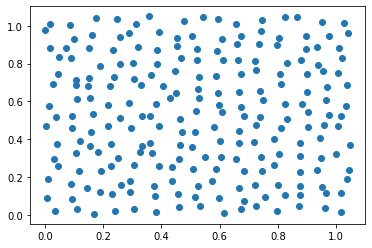

In [15]:
%%space flat-torus

n=15
t = np.linspace(0,1,n)
x,y = np.meshgrid(t,t)
x = np.reshape(x, (n*n,1))
y = np.reshape(y, (n*n,1))
X = np.hstack([x, y]) + 0.05*np.random.random((n*n,2))
plt.scatter(X[:,0], X[:,1])

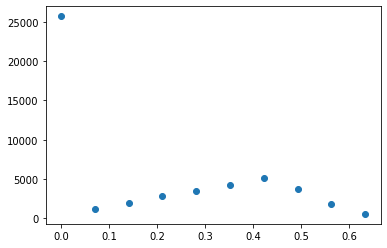

In [16]:
%%space flat-torus

distances = flat_torus_distance(X)
# let's plot some distances to make sure
# we can later choose a filtration threshold that
# makes sense
hist, bins = np.histogram(np.triu(distances), bins=10)
hist.shape, bins.shape
plt.scatter(bins[:-1], hist)

In [17]:
%%space flat-torus

distances.shape

(225, 225)

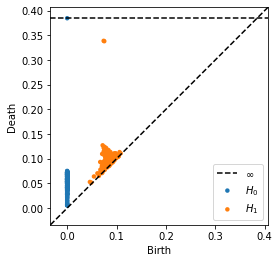

In [18]:
%%space flat-torus

flat_torus_result = ripser(distances, distance_matrix=True, do_cocycles=True)
plot_diagrams(flat_torus_result['dgms'])

Produce scatter plots as in the previous exercise for the two most persistent points. Which threshold $r$ did you choose, and why?

By the previous histogram we can see that most of the distances will be limited to half the width of our square; this makes sense as if two points are "very distant" in our original square they won't be in one of the other translations achievable.

Here we take the two most persisten points to be the last two to die, no the two with the longest $death - birth$

From the diagram we can see that we can disregard looking at 0-simplices as they won't be the one surviving the longest.

In [22]:
%%space flat-torus

dtype = [('birth', float), ('death', float)]
all_features = flat_torus_result['dgms'][1] # only take barcodes for 1-simplices
all_cocycles = np.asarray(flat_torus_result['cocycles'][1]) # only take 1-co-cycles
sorted_features = all_features[:,1].argsort() # get the indexes that would sort the barcodes wrt to death

persistent_points = all_cocycles[sorted_features] # sort cocycles

a, b = persistent_points[-2], persistent_points[-1] # take the two surviging the longest

In [20]:
def drawLineColored(X, C):
    for i in range(X.shape[0]-1):
        plt.plot(X[i:i+2, 0], X[i:i+2, 1], c=C[i, :], lineWidth = 3)

c = plt.get_cmap('Greys')
        
def plotCocycle2D(D, X, cocycle, thresh):
    """Plot the cocycle over the datapoints X.
    
    Given a 2D point cloud X, display a cocycle projected
    onto edges under a given threshold "thresh"
    
    :param D : distance matrix
    :param X : positions of my vertices
    :param cocycle: 
    :type  cocycle: numpy.ndarray(k,3)
    :param  thresh: draw only edges under the threshold length
    
    width & height: plot dimensions
    """
    N = X.shape[0]
    t = np.linspace(0, 1, 10)
    c = plt.get_cmap('Greys')
    C = c(np.array(np.round(np.linspace(0, 255, len(t))), dtype=np.int32))
    C = C[:, 0:3]

    for i in range(N):
        for j in range(N):
            if D[i, j] <= thresh:
                Y = np.zeros((len(t), 2))
                Y[:, 0] = X[i, 0] + t*(X[j, 0] - X[i, 0])
                Y[:, 1] = X[i, 1] + t*(X[j, 1] - X[i, 1])
                drawLineColored(Y, C)
    # Plot cocycle projected to edges under the chosen threshold
    for k in range(cocycle.shape[0]):
        # this edge goes from vertex i to vertex j
        # we associate val to the edge
        [i, j, val] = cocycle[k, :]
        # if the distance between two vertices is less
        # than the threshold then we can plot it
        if D[i, j] <= thresh:
            i, j = min(i, j), max(i, j)
            a = 0.5*(X[i, :] + X[j, :])
            plt.text(a[0], a[1], '%g'%val, color='b')
            
    # always plot vertex labels otherwise it gets too confusing
    for i in range(N):
        plt.text(X[i, 0], X[i, 1], '%i'%i, color='r')
    plt.axis('equal')

In the following scatterplots we are drawing an edge from point p to q when p and q are less distant than the threshold but this is just a representation of the link, not of the distance as we most likely would have to wrap around the edge to make edges visually represent a more faithful distance.

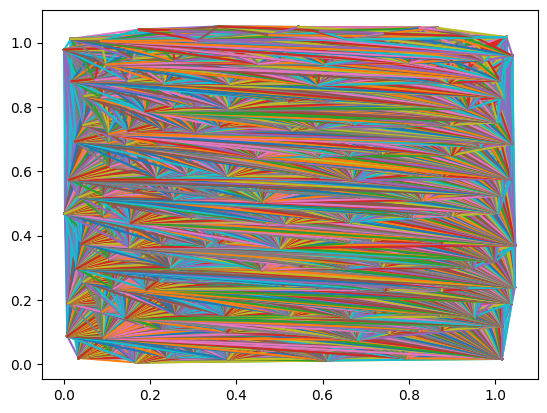

In [29]:
%%space flat-torus

#plotCocycle2D(distances, X, a, 0.01) #here lies poor performance
scatter_cocycle(distances, X, a, np.infty)  # we did ART!

10 loops, best of 5: 26.4 ms per loop


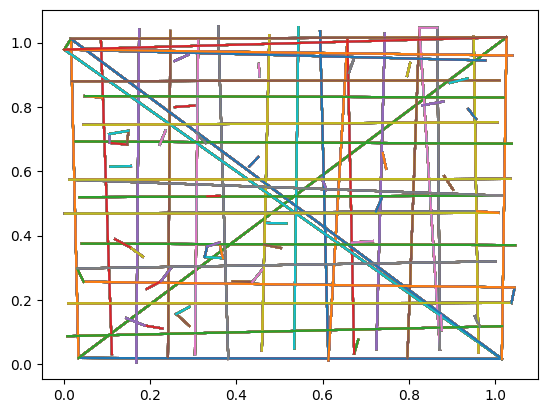

In [28]:
%%space flat-torus

scatter_cocycle(distances, X, b, 0.05)

1 loop, best of 5: 1.92 s per loop


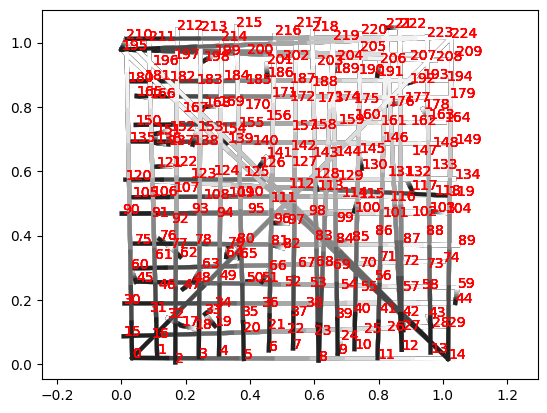

In [27]:
%%space flat-torus

%timeit plotCocycle2D(distances, X, a, 0.05)